In [594]:
import numpy as np
import matplotlib.pyplot as plt

In [595]:
def tdma_solve(a, b, c, d):
    n = len(d)
    c_prime = np.zeros(n-1)
    d_prime = np.zeros(n)
    x = np.zeros(n)
    
    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]
    
    for i in range(1, n-1):
        denom = b[i] - a[i] * c_prime[i-1]
        if abs(denom) < 1e-14: denom = 1e-14 # Divisonn by zero might cause porblems
        c_prime[i] = c[i] / denom
        d_prime[i] = (d[i] - a[i] * d_prime[i-1]) / denom
    
    denom = b[n-1] - a[n-1] * c_prime[n-2]
    if abs(denom) < 1e-14:
        denom = 1e-14
    d_prime[n-1] = (d[n-1] - a[n-1] * d_prime[n-2]) / denom
    
    x[n-1] = d_prime[n-1]
    for i in range(n-2, -1, -1): #reverse for back substitution
        x[i] = d_prime[i] - c_prime[i] * x[i+1]
    
    return x

In [596]:
xc = np.loadtxt('xc.dat')
yc = np.loadtxt('yc.dat')
u_flat = np.loadtxt('u.dat')
v_flat = np.loadtxt('v.dat')

n = len(u_flat)
nx = int(np.sqrt(n))  # Should be 27
ny = n // nx          # Should be 27

print(f"Grid size: {nx} x {ny} = {n} cells")

# Reshape to 2D arrays (CRITICAL: Fortran order, then transpose)
U = u_flat.reshape((ny, nx), order='F').T
V = v_flat.reshape((ny, nx), order='F').T

Grid size: 27 x 27 = 729 cells


In [597]:
rho = 1.0                    # Density
Gamma = 1.0 / 50.0          # k/cp = 0.02
alpha = 0.2
L = xc.max()                  # Domain length
H = yc.max()                  # Domain height
h_A = 0.068 * H             # Inlet A height
h_B = 0.068 * H             # Inlet B height  
h_C = 0.068 * H             # Outlet C height

U_A = 0.0      # Inlet A velocity
U_B = 0.0        # Inlet B velocity (no flow)
U_C = 0.0        # Outlet C velocity
V_D = 0.0        # Top boundary velocity
T_A = 20.0       # Inlet A temperature (°C)
T_wall = 50.0    # Right wall temperature (°C)

node_block = 4

max_iter = 500
tolerance = 1e-5
tolerance = 0.0001

In [598]:
U[:6, 22:] = 1.0 # Ua
V[13:17, 20:] = 0 # Vd #-
U[:6, :8] = 0 # Ub     # -
U[20:, :8] = 1.0 # Uc

In [599]:
T = np.ones((nx, ny)) * 35.0  # Initial guess midway between boundaries


T[0, 0] = T_A         # Inlet A
    
T[-1, nx-1] = T_wall  # Right wall at x=L (except outlet)

print(f"\nInitial T range: [{T.min():.2f}, {T.max():.2f}]°C")


Initial T range: [20.00, 50.00]°C


In [600]:
# x = np.linspace(xc.min(), xc.max(), nx)
# y = np.linspace(yc.min(), yc.max(), ny)

x = 0.5 * (xc[:-1] + xc[1:])
x = np.insert(x, 0, 0)
x = np.insert(x, len(x), 2)

y = 0.5 * (yc[:-1] + yc[1:])
y = np.insert(y, 0, 0)
y = np.insert(y, len(y), 2)

# dx, dy = x[1] - x[0], y[1] - y[0]

In [601]:
x_direction = True
y_direction = True

In [602]:
dx_cells = np.zeros(nx)
dy_cells = np.zeros(ny)

for i in range(nx):
    if i == 0:
        dx_cells[i] = x[1] - x[0]
    elif i == nx-1:
        dx_cells[i] = x[-1] - x[-2]
    else:
        dx_cells[i] = 0.5 * (x[i+1] - x[i-1])

for j in range(ny):
    if j == 0:
        dy_cells[j] = y[1] - y[0]
    elif j == ny-1:
        dy_cells[j] = y[-1] - y[-2]
    else:
        dy_cells[j] = 0.5 * (y[j+1] - y[j-1])

In [603]:
Pe_threshold = 2

In [604]:
cp = 100

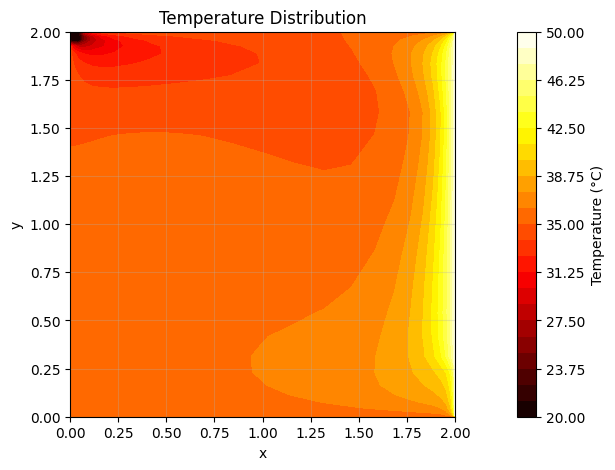

In [ ]:
epsilon_history = []
for iteration in range(max_iter):
    Pe_history = []
    T_old = T.copy()
    
    if x_direction:
        # ========================================================================
        # X-DIRECTION SWEEP
        # ========================================================================
        for j in range(1, ny-1):
            a = np.zeros(nx)
            b = np.zeros(nx)
            c = np.zeros(nx)
            d = np.zeros(nx)
            
            for i in range(1, nx-1):

                dx = dx_cells[i]
                dy = dy_cells[j]

                # Face velocities
                u_e = 0.5 * (U[i,j] + U[i+1,j])
                u_w = 0.5 * (U[i,j] + U[i-1,j])
                v_n = 0.5 * (V[i,j] + V[i,j+1])
                v_s = 0.5 * (V[i,j] + V[i,j-1])
                
                # Convective fluxes
                F_e = rho * u_e * dy
                F_w = rho * u_w * dy
                F_n = rho * v_n * dx
                F_s = rho * v_s * dx
                
                # Diffusive conductances
                D_e = Gamma * dy / dx
                D_w = Gamma * dy / dx
                D_n = Gamma * dx / dy
                D_s = Gamma * dx / dy
                
                # Peclet numbers
                Pe_e = F_e / D_e #if abs(D_e) > 1e-12 else 1e10
                Pe_w = F_w / D_w #if abs(D_w) > 1e-12 else 1e10
                Pe_n = F_n / D_n #if abs(D_n) > 1e-12 else 1e10
                Pe_s = F_s / D_s #if abs(D_s) > 1e-12 else 1e10

                Pe_history.append(((Pe_e + Pe_w + Pe_n + Pe_s)/4))
                
                # Hybrid scheme coefficients
                if abs(Pe_e) < Pe_threshold:
                    a_E = D_e - 0.5 * F_e
                else:
                    a_E = D_e + max(0.0, -F_e)
                
                if abs(Pe_w) < Pe_threshold:
                    a_W = D_w + 0.5 * F_w
                else:
                    a_W = D_w + max(0.0, F_w)
                
                if abs(Pe_n) < Pe_threshold:
                    a_N = D_n - 0.5 * F_n
                else:
                    a_N = D_n + max(0.0, -F_n)
                
                if abs(Pe_s) < Pe_threshold:
                    a_S = D_s + 0.5 * F_s
                else:
                    a_S = D_s + max(0.0, F_s)
                
                # Source term (lagged cross-direction)
                S = a_N * T[i, j+1] + a_S * T[i, j-1]
                
                # Central coefficient
                a_P = a_E + a_W + a_N + a_S
                
                # Assemble tridiagonal system
                a[i] = -a_W # lower diagonal
                b[i] = a_P  # the middle wala part
                c[i] = -a_E # uppser diagonal
                d[i] = S    # the known stuff
            
            # Left boundary (x = 0)
            b[0] = 1.0
            c[0] = 0.0
            if j == ny-1:  # Now this will actually execute!
                d[0] = T_A  # Top-left corner
            else:
                d[0] = T[0, j]  # Other left boundary nodes
            
            # Right boundary (x = L)
            a[-1] = 0.0
            b[-1] = 1.0
            if j == 0:
                d[-1] = T[-1, j]  # Bottom-right
            else:
                d[-1] = T_wall  # Other right boundary nodes
            
            T_new = tdma_solve(a, b, c, d)
            T[:, j] = alpha * T_new + (1.0 - alpha) * T[:, j]
    
    if y_direction: 
        # ========================================================================
        # Y-DIRECTION SWEEP
        # ========================================================================
        for i in range(1, nx-1):
            a = np.zeros(ny)
            b = np.zeros(ny)
            c = np.zeros(ny)
            d = np.zeros(ny)
            
            for j in range(1, ny-1):
                # Face velocities
                u_e = 0.5 * (U[i,j] + U[i+1,j])
                u_w = 0.5 * (U[i,j] + U[i-1,j])
                v_n = 0.5 * (V[i,j] + V[i,j+1])
                v_s = 0.5 * (V[i,j] + V[i,j-1])
                
                # Fluxes
                F_e = rho * u_e * dy
                F_w = rho * u_w * dy
                F_n = rho * v_n * dx
                F_s = rho * v_s * dx
                
                # Diffusion
                D_e = Gamma * dy / dx
                D_w = Gamma * dy / dx
                D_n = Gamma * dx / dy
                D_s = Gamma * dx / dy
                
                # Peclet
                Pe_e = F_e / D_e #if abs(D_e) > 1e-12 else 1e10
                Pe_w = F_w / D_w #if abs(D_w) > 1e-12 else 1e10
                Pe_n = F_n / D_n #if abs(D_n) > 1e-12 else 1e10
                Pe_s = F_s / D_s #if abs(D_s) > 1e-12 else 1e10
                
                # Hybrid scheme
                if abs(Pe_e) < Pe_threshold:
                    a_E = D_e - 0.5 * F_e
                else:
                    a_E = D_e + max(0.0, -F_e)
                
                if abs(Pe_w) < Pe_threshold:
                    a_W = D_w + 0.5 * F_w
                else:
                    a_W = D_w + max(0.0, F_w)
                
                if abs(Pe_n) < Pe_threshold:
                    a_N = D_n - 0.5 * F_n
                else:
                    a_N = D_n + max(0.0, -F_n)
                
                if abs(Pe_s) < Pe_threshold:
                    a_S = D_s + 0.5 * F_s
                else:
                    a_S = D_s + max(0.0, F_s)
                
                # Source (lagged)
                S = a_E * T[i+1, j] + a_W * T[i-1, j]
                
                a_P = a_E + a_W + a_N + a_S
                
                # Assemble
                a[j] = -a_S
                b[j] = a_P
                c[j] = -a_N
                d[j] = S
            
            # Bottom boundary (y = 0)
            b[0] = 1.0
            c[0] = 0.0
            if i == 0:
                d[0] = T[i, 0]  # Left boundary
            else:
                d[0] = T[i, 0]  # Other bottom nodes
            
            # Top boundary (y = H)
            a[-1] = 0.0
            b[-1] = 1.0
            if i == 0:
                d[-1] = T_A  # Top-left corner (can also enforce here)
            else:
                d[-1] = T[i, -1]  # Other top nodes
            
            T_new = tdma_solve(a, b, c, d)
            T[i, :] = alpha * T_new + (1.0 - alpha) * T[i, :]
    
    
    T[:node_block, nx-node_block:] = T_A     # Top left
    # T[:node_block, :node_block] = T_A        # Bottom left
    # for p in range(ny):
    #     T[:node_block, p] = T_A * p     

    # T[ny-node_block:, nx-node_block:] = T_A  # Top right
    # T[ny-node_block:, :node_block] = T_A     # Bottom right
    
    # ========================================================================
    # CONVERGENCE CHECK
    # ========================================================================
    if iteration % 1 == 0:
        residual_sum = 0.0
        flux_sum_total = 0.0
        
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                u_e = 0.5 * (U[i,j] + U[i+1,j])
                u_w = 0.5 * (U[i,j] + U[i-1,j])
                v_n = 0.5 * (V[i,j] + V[i,j+1])
                v_s = 0.5 * (V[i,j] + V[i,j-1])
                
                F_e = rho * u_e * dy
                F_w = rho * u_w * dy
                F_n = rho * v_n * dx
                F_s = rho * v_s * dx
                
                D_e = Gamma * dy / dx
                D_w = Gamma * dy / dx
                D_n = Gamma * dx / dy
                D_s = Gamma * dx / dy
                
                Pe_e = F_e / D_e if D_e > 1e-12 else 0
                Pe_w = F_w / D_w if D_w > 1e-12 else 0
                Pe_n = F_n / D_n if D_n > 1e-12 else 0
                Pe_s = F_s / D_s if D_s > 1e-12 else 0
                
                if abs(Pe_e) < Pe_threshold:
                    a_E = D_e - 0.5 * F_e
                else:
                    a_E = D_e + max(0.0, -F_e)
                
                if abs(Pe_w) < Pe_threshold:
                    a_W = D_w + 0.5 * F_w
                else:
                    a_W = D_w + max(0.0, F_w)
                
                if abs(Pe_n) < Pe_threshold:
                    a_N = D_n - 0.5 * F_n
                else:
                    a_N = D_n + max(0.0, -F_n)
                
                if abs(Pe_s) < Pe_threshold:
                    a_S = D_s + 0.5 * F_s
                else:
                    a_S = D_s + max(0.0, F_s)
                
                a_P = a_E + a_W + a_N + a_S
                
                residual = abs(a_E * T[i+1, j] + a_W * T[i-1, j] + 
                             a_N * T[i, j+1] + a_S * T[i, j-1] - a_P * T[i, j])
                
                residual_sum += residual
                
                flux_sum = (abs(a_E * T[i+1, j]) + abs(a_W * T[i-1, j]) + 
                           abs(a_N * T[i, j+1]) + abs(a_S * T[i, j-1]) + 
                           abs(a_P * T[i, j]))
                flux_sum_total += flux_sum
        
        epsilon = residual_sum / (flux_sum_total + 1e-20)
        epsilon_history.append(epsilon)
        
        if iteration % 100 == 0:
            print(f"Iteration {iteration:4d}: ε = {epsilon:.6e}, T ∈ [{T.min():.2f}, {T.max():.2f}]°C")
        
        if epsilon < tolerance:
            print(f"\nConverged at iteration {iteration}")
            print(f"  Residual ε = {epsilon:.6e}")
            break

if iteration == max_iter - 1:
    print(f"\nReached maximum iterations ({max_iter})")


X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize=(16, 5))

# Temperature contour
ax1 = fig.add_subplot(111)
levels = np.linspace(T.min(), T.max(), 25)
cf = ax1.contourf(X, Y, T.T, levels=levels, cmap='hot')
plt.colorbar(cf, ax=ax1, label='Temperature (°C)')

# Add labeled contour lines
# contours = ax1.contour(X, Y, T.T, levels=10, colors='black', alpha=0.5, linewidths=1)
# ax1.clabel(contours, inline=True, fontsize=8, fmt='%.1f°C')  # Add labels to contours

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Temperature Distribution')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)


# Velocity field
# ax2 = fig.add_subplot(122)
# skip = max(1, nx//15)
# vel_mag = np.sqrt(U**2 + V**2)
# cf2 = ax2.contourf(X, Y, vel_mag.T, levels=20, cmap='viridis', alpha=0.6)
# plt.colorbar(cf2, ax=ax2, label='Velocity magnitude')
# ax2.quiver(X[::skip,::skip], Y[::skip,::skip], 
#            U.T[::skip,::skip], V.T[::skip,::skip], alpha=0.7)
# ax2.set_xlabel('x (m)')
# ax2.set_ylabel('y (m)')
# ax2.set_title('Velocity Field')
# ax2.set_aspect('equal')
# ax2.grid(True, alpha=0.3)

In [606]:
# (0,26)  (1,26)  (2,26)  ...  (26,26)  ← Top row
# (0,25)  (1,25)  (2,25)  ...  (26,25)
# (0,24)  (1,24)  (2,24)  ...  (26,24)
  
# (0,0)   (1,0)   (2,0)   ...  (26,0)   ← Bottom row


In [607]:
ny-node_block

23

In [608]:
# Print corner values to verify
print("Corner temperatures:")
print(f"T[0, 0] (bottom-left): {T[0, 0]:.2f}°C")
print(f"T[0, -1] (top-left): {T[0, -1]:.2f}°C")
print(f"T[-1, 0] (bottom-right): {T[-1, 0]:.2f}°C")
print(f"T[-1, -1] (top-right): {T[-1, -1]:.2f}°C")


Corner temperatures:
T[0, 0] (bottom-left): 20.00°C
T[0, -1] (top-left): 20.00°C
T[-1, 0] (bottom-right): 35.00°C
T[-1, -1] (top-right): 50.00°C


In [609]:
pp = np.array([[1,2,3], [4,5,6], [7,8,9]])
print(pp)
pp[1:,1:]

[[1 2 3]
 [4 5 6]
 [7 8 9]]


array([[5, 6],
       [8, 9]])

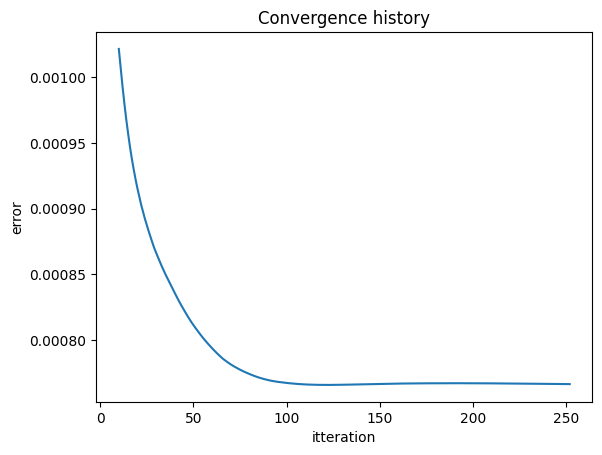

In [610]:
a = 10
b = 253
plt.plot(range(len(epsilon_history))[a:b], epsilon_history[a:b])
plt.title("Convergence history")
plt.xlabel("itteration")
plt.ylabel("error")
plt.show()

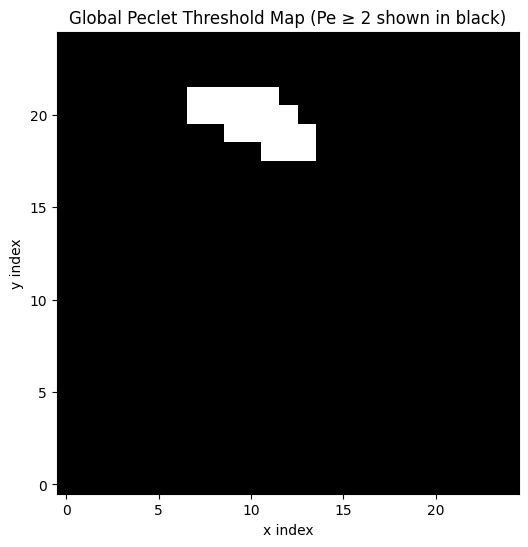

In [611]:
Pe_array = np.array(Pe_history)
n = int(len(Pe_array)**0.5)
Pe_grid = Pe_array.reshape((n, n))

# Apply threshold
threshold = Pe_threshold
binary_grid = (Pe_grid >= threshold).astype(int)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(binary_grid, cmap='gray', origin='lower')
plt.title(f'Global Peclet Threshold Map (Pe ≥ {threshold} shown in black)')
plt.xlabel('x index')
plt.ylabel('y index')

# Optional gridlines for better visibility
plt.grid(False)
plt.show()